<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from  datetime import datetime as DT
import time

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    '''
    предобработка данных  + создание дополнительных признаков
    на вход получаем :
    - путь к папке с файлами
    - путь к частотному словарю сохраненному в формате pickle
        формат словаря
            site_str : (site_id, site_freq)
    - список с заголовками итогового DataFrame
    - длинну сессии и размер окна    
    
    выход:
    DataFrame:
    site1 - site_W (по количеству сайтов "окне")
    time_diff1 - time_diff(W-1) (разница времени в секундах межжду посещениями сайтов)
    session_timespan - суммарная продолжительность сессии в секундах
    #unique_sites - число уникальных сайтов в сессии
    start_hour - час начала сессии (определяется по времени первого сайта)
    day_of_week - день недели сессии (определяется по времени первого сайта)
    target - id пользователя
    
    '''
    # получим список с именами и путями к файлам и отсортируем его
    f_names = glob(path_to_csv_files+'/*.csv')
    f_names.sort()

    # восстановим частотный словарь из picklie
    with open(site_freq_path, 'rb') as site_freq_pkl:
        dict_freq = pickle.load(site_freq_pkl)


    # создадим пустой список в который будем добавлять данные по сесиям
    list_of_sessions = []

    # проходим повторным циклом по всем файлам что-бы заполнить данные о сессиях в DataFrame
    for f_name in f_names:
        user_id = int(f_name[-8:-4]) # из названия файла выделим user_id
        user_sessions = pd.read_csv(f_name) # считаем данные по пользователю в DataFrame
        # преобразуем timestamp
        user_sessions['timestamp'] = user_sessions['timestamp'].apply(lambda s: DT.strptime(s, "%Y-%m-%d %H:%M:%S"))
        file_len = user_sessions.shape[0]
        user_sessions_num  = file_len // window_size + (file_len % window_size > 0 ) # определим общее количество сессий у пользователя
        # и пройдемся по всем сессиям пользователя циклом  
        for i in range(user_sessions_num):
            session_id = i+1 # сохраним id сессии
            # сделаем срез по одной сессии и добавим её в DataFrame
            first_elem = i*window_size # первый элемент, в новой сессии
            last_elem = min(i*window_size + session_length, user_sessions.shape[0]) # последний элемент в новой сессии
            one_user_sess = user_sessions.iloc[first_elem:last_elem, 1]
            # определим день недели сессии по дате первого сайта
            day_of_week = DT.weekday(user_sessions.iloc[first_elem, 0])
            # определим час сессии по времени первого сайта
            start_hour = user_sessions.iloc[first_elem, 0].hour
            # сохраним данные по интервалам времени между посещениями сайтов в список
            timespans = user_sessions.iloc[first_elem:last_elem, 0]
            time_diffs = [(timespans[i+1] - timespans[i]).total_seconds() for i in range(first_elem, last_elem-1)]
            # если это последняя сессия и количество записей меньше то заполним нулями
            while len(time_diffs) < session_length -1:
                time_diffs+=[0]

            sess_timespan = sum(time_diffs)
            #сохраним данные по посещенным сайтам  список
            sites_id_list = [dict_freq[site][0] for site in  one_user_sess]
            unique_sites = len(set(sites_id_list)) # количество уникальных сайтов в сессии
            # если это последняя сессия и количество записей меньше чем указанная длинна добьем нулями
            while len(sites_id_list) < session_length:
                sites_id_list+=[0]

            list_of_sessions.append( sites_id_list + time_diffs + \
                                    [sess_timespan, unique_sites, start_hour, day_of_week, user_id] )

    # на основании списка создалим DataFrame
    Sessions = pd.DataFrame(list_of_sessions, columns=feature_names) 
    return Sessions

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 21.7 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,193,586,133,3,133,133,3,133,204,133,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31
1,421,192,675,254,133,31,398,3925,218,55,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31
2,55,3,55,55,5,295,421,338,904,55,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31
3,477,4731,477,55,55,55,55,976,199,123,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31
4,342,55,5,3921,259,211,3818,2113,699,2113,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 3min 28s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features =  ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

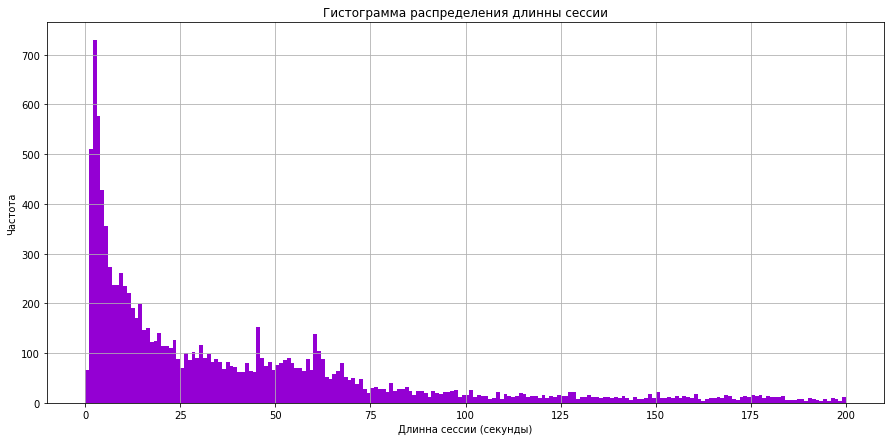

In [17]:
plt.xlabel('Длинна сессии (секунды)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения длинны сессии')
train_data_10users['session_timespan'].hist(bins = 200, range = (0, 200), color = 'darkviolet', figsize = (15, 7))

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

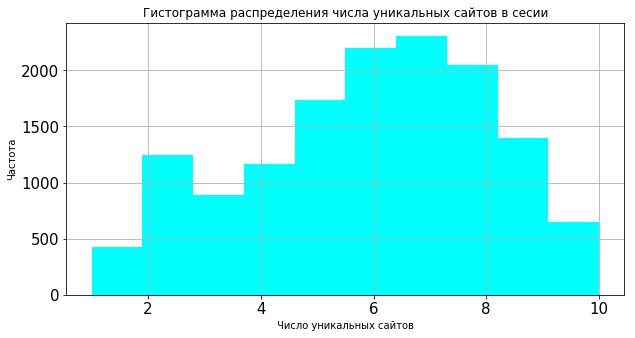

In [18]:
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Частота')
plt.title('Гистограмма распределения числа уникальных сайтов в сесии')
train_data_10users['#unique_sites'].hist(bins = 10, xlabelsize = 15, ylabelsize = 15, color = 'aqua', figsize = (10, 5))

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

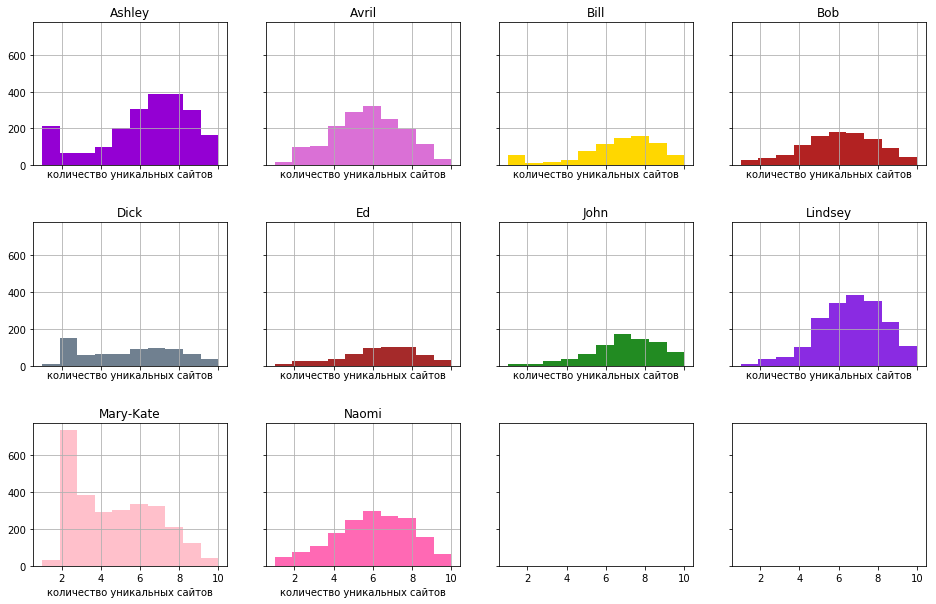

In [124]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace= 0.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax=axes[idx // 4, idx % 4]
    ax.set_title(user)
    sub_df['#unique_sites'].hist(ax=ax, bins = 10, color = color_dic[user])
    ax.set_xlabel('количество уникальных сайтов')
    


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

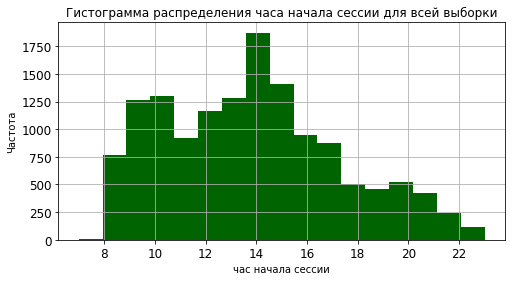

In [58]:
plt.title('Гистограмма распределения часа начала сессии для всей выборки')
plt.xlabel('час начала сессии')
plt.ylabel('Частота')
train_data_10users['start_hour'].hist(bins = 17, xlabelsize = 12, ylabelsize = 12, color = 'darkgreen', figsize = (8, 4))

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

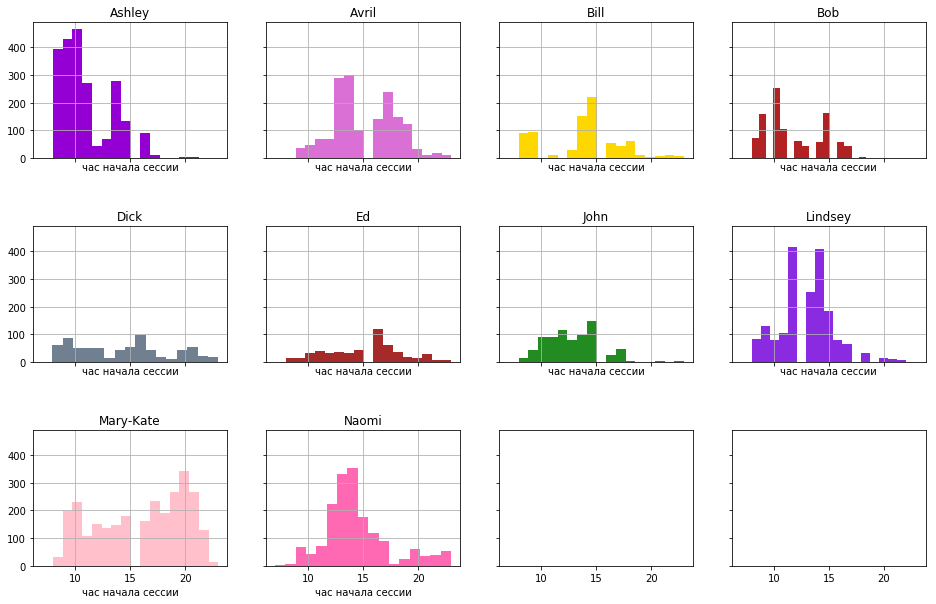

In [112]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace= 0.5)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax=axes[idx // 4, idx % 4]
    ax.set_title(user)
    sub_df['start_hour'].hist(ax=ax, bins = 17, color = color_dic[user])
    ax.set_xlabel('час начала сессии')


**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

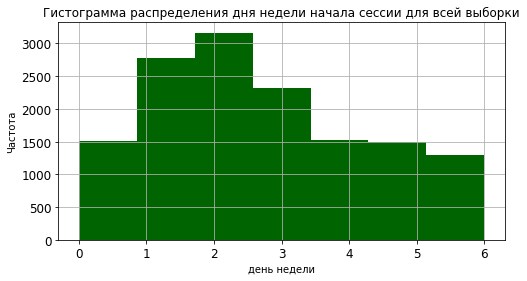

In [79]:
plt.title('Гистограмма распределения дня недели начала сессии для всей выборки')
plt.xlabel('день недели')
plt.ylabel('Частота')
train_data_10users['day_of_week'].hist(bins = 7, xlabelsize = 12, ylabelsize = 12, color = 'darkgreen', figsize = (8, 4))


**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

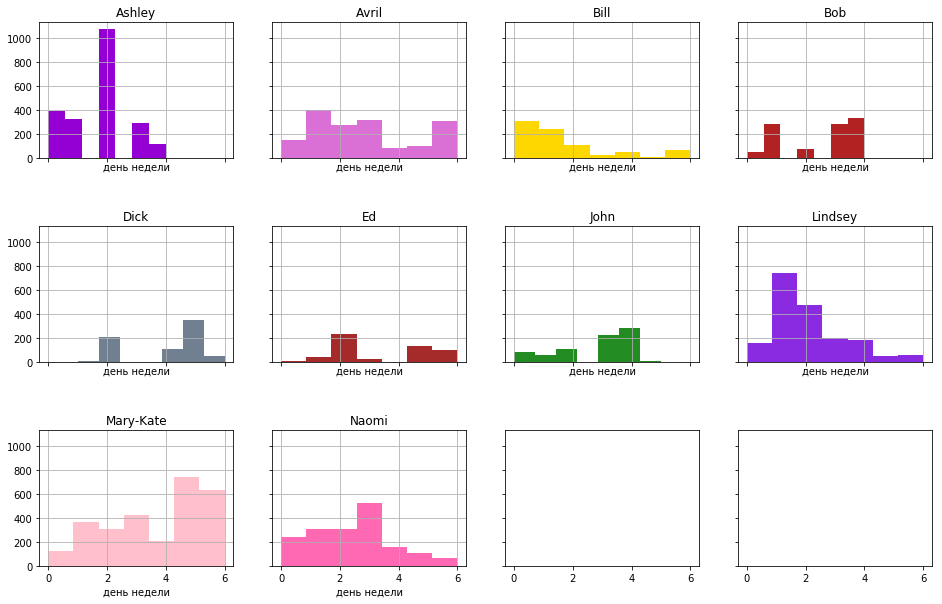

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
#fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plt.subplots_adjust(hspace= 0.5)

WeekDaysList = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
WeekdaysDict = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax=axes[idx // 4, idx % 4]
    ax.set_title(user)
    #ax.set(user)
    #min_day = sub_df['day_of_week'].min()
    #max_day = sub_df['day_of_week'].max()
    #ax.set_xticklabels(WeekDaysList)
    sub_df['day_of_week'].hist(ax=ax, bins = 7, xlabelsize = 10, ylabelsize = 10, color = color_dic[user])
    ax.set_xlabel('день недели')

In [126]:
WeekdaysDict

{0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}

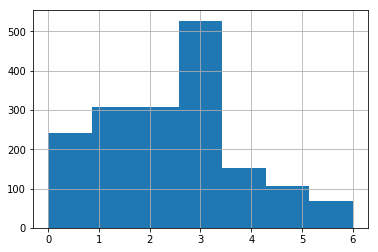

In [95]:
sub_df['day_of_week'].hist(bins = 7)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 